In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, v2, CenterCrop

class RaceDataset(Dataset):
    def __init__(self, root='/kaggle/input/huhuhu6/race/', train=True, transform=None):
        super().__init__()
        self.image_paths = []
        self.labels = []
        self.categories = ["caucasian", "mongoloid", "negroid"]
        self.transform = transform
        
        if train:
            data_path = os.path.join(root, 'train')
        else:
            data_path = os.path.join(root, 'valid')
        
        for i, category in enumerate(self.categories):
            data_files = os.path.join(data_path,category)
            for item in os.listdir(data_files):
                path = os.path.join(data_files,item)
                self.image_paths.append(path)
                self.labels.append(i)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 
root = '/kaggle/input/huhuhu6/race/'
train_dataset = RaceDataset(root=root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = RaceDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# for images, labels in train_loader:
#     print(images.shape, labels.shape)
# for images, labels in test_loader:
#     print(images.shape, labels.shape)

16745
3058


In [6]:
import torch
# from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, RandomResizedCrop

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch
import torch.nn as nn

class MyEffnet(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.backbone = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        self.backbone.classifier[1] = nn.Linear(1280, n_classes)
    
    def forward(self, x):
        x = self.backbone(x)
        return x

In [8]:
x = torch.randn(16, 3, 224, 224)
model = MyEffnet()
# print(model)
print(model(x).shape)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 87.0MB/s]


torch.Size([16, 3])


In [14]:
import torch.optim as optim
from tqdm import tqdm
epochs = 20
batch_size = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)#optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_workers = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
#         ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_transform = Compose([
        ToPILImage(),
        Resize(256),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) 

In [15]:
train_dataset = RaceDataset(root= root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = RaceDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

16745
3058


In [27]:
model = MyEffnet().to(device)
if os.path.exists('last.pt'):
    if torch.cuda.is_available():
        model.load_state_dict(torch.load('last.pt'))
    else:
        model.load_state_dict(torch.load('last.pt', map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5) 

In [28]:
best_acc = 0
best_model = MyEffnet().to(device)
if os.path.exists('best.pt'):
    best_model.load_state_dict(torch.load('best.pt',map_location=torch.device('cpu')))
    best_model.eval()
    all_predictions_best = []
    all_labels_best = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions_best.extend(predictions)
            all_labels_best.extend(labels.cpu())     
    all_labels_best = [label.item() for label in all_labels_best]
    all_predictions_best = [prediction.item() for prediction in all_predictions_best]
    best_acc = accuracy_score(all_labels_best, all_predictions_best)

In [29]:
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    all_predictions = []
    all_labels = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu())
    all_labels = [label.item() for label in all_labels]
    all_predictions = [prediction.item() for prediction in all_predictions]
    acc = accuracy_score(all_labels, all_predictions)
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
    torch.save(model.state_dict(), 'last.pt')
    if acc > best_acc:
        torch.save(model.state_dict(), 'best.pt')
        best_acc=acc
    # writer.add_scalars('Val/Accuracy', acc, epoch)

Epoch: 1/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:37<00:00,  9.63it/s]


Epoch: 1/20 Test Loss: 1.9539 Test Acc: 0.9359


Epoch: 2/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:37<00:00,  9.65it/s]


Epoch: 2/20 Test Loss: 1.5931 Test Acc: 0.9366


Epoch: 3/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:36<00:00,  9.65it/s]


Epoch: 3/20 Test Loss: 1.8277 Test Acc: 0.9349


Epoch: 4/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:36<00:00,  9.65it/s]


Epoch: 4/20 Test Loss: 2.0568 Test Acc: 0.9372


Epoch: 5/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:35<00:00,  9.70it/s]


Epoch: 5/20 Test Loss: 1.8933 Test Acc: 0.9379


Epoch: 6/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:35<00:00,  9.72it/s]


Epoch: 6/20 Test Loss: 1.5358 Test Acc: 0.9375


Epoch: 7/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:36<00:00,  9.69it/s]


Epoch: 7/20 Test Loss: 1.5428 Test Acc: 0.9353


Epoch: 8/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:35<00:00,  9.70it/s]


Epoch: 8/20 Test Loss: 1.7120 Test Acc: 0.9349


Epoch: 9/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:36<00:00,  9.69it/s]


Epoch: 9/20 Test Loss: 1.6158 Test Acc: 0.9356


Epoch: 10/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:37<00:00,  9.64it/s]


Epoch: 10/20 Test Loss: 1.5566 Test Acc: 0.9379


Epoch: 11/20 Iter: 2094 Loss: 2.0962: 100%|██████████| 2094/2094 [03:36<00:00,  9.67it/s]


Epoch: 11/20 Test Loss: 1.5580 Test Acc: 0.9398


Epoch: 12/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:36<00:00,  9.68it/s]


Epoch: 12/20 Test Loss: 2.1483 Test Acc: 0.9408


Epoch: 13/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:35<00:00,  9.72it/s]


Epoch: 13/20 Test Loss: 1.4687 Test Acc: 0.9375


Epoch: 14/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:36<00:00,  9.69it/s]


Epoch: 14/20 Test Loss: 1.5651 Test Acc: 0.9372


Epoch: 15/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:36<00:00,  9.67it/s]


Epoch: 15/20 Test Loss: 1.5309 Test Acc: 0.9375


Epoch: 16/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:37<00:00,  9.64it/s]


Epoch: 16/20 Test Loss: 1.6554 Test Acc: 0.9405


Epoch: 17/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:36<00:00,  9.68it/s]


Epoch: 17/20 Test Loss: 2.0343 Test Acc: 0.9398


Epoch: 18/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:37<00:00,  9.64it/s]


Epoch: 18/20 Test Loss: 1.9717 Test Acc: 0.9405


Epoch: 19/20 Iter: 2094 Loss: 0.0001: 100%|██████████| 2094/2094 [03:36<00:00,  9.67it/s]


Epoch: 19/20 Test Loss: 1.8003 Test Acc: 0.9382


Epoch: 20/20 Iter: 2094 Loss: 0.0000: 100%|██████████| 2094/2094 [03:36<00:00,  9.65it/s]


Epoch: 20/20 Test Loss: 1.5422 Test Acc: 0.9379


In [30]:
test_model = MyEffnet().to(device)
test_model.load_state_dict(torch.load('best.pt', map_location=torch.device('cpu')))
test_model.eval()

MyEffnet(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24

In [33]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
categories = ["caucasian", "mongoloid", "negroid"]
indices = random.sample(range(0, test_dataset.__len__()), 8)
print(indices)
images = torch.stack([test_dataset.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]
predictions = torch.argmax(test_model(images.to(device)).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)

[1325, 431, 1738, 2725, 2294, 947, 1061, 2435]
torch.Size([8, 3, 224, 224])
[0, 0, 1, 1, 1, 0, 0, 1]
tensor([0, 0, 1, 1, 1, 0, 0, 1])


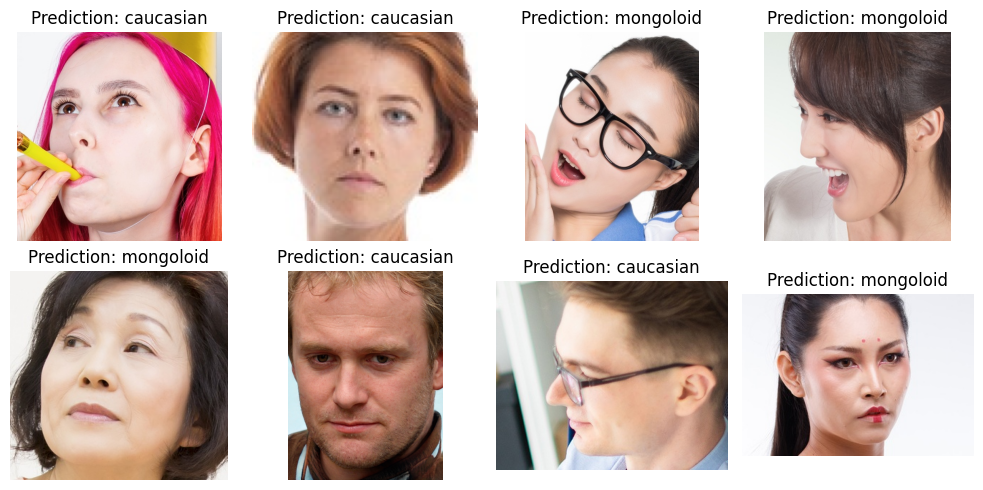

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for i in range(8):
  img = cv2.imread(test_dataset.image_paths[indices[i]])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()